In [109]:
import xarray as xr, geopandas as gpd, pandas as pd, numpy as np, regionmask, rasterio as rio
import datetime, glob, re
from functools import reduce
from IPython.display import clear_output


import matplotlib.pyplot as plt
import cartopy

mapproj = cartopy.crs.PlateCarree()

sf = gpd.read_file("sf_studyregion/")

# Study region shapefile

In [51]:
mx = regionmask.defined_regions.natural_earth_v5_1_2.countries_50.to_geodataframe().set_index("abbrevs").loc[["MX"]]

xn,xx,yn,yx = [-102,-94.8,16.8,26.1]
sf04 = gpd.read_file("sf_hybas04/").clip((xn,yn,xx,yx))
sf04 = sf04.loc[[150,151,152,153]]
sf = sf04.dissolve().explode()

sf = sf.loc[sf.geometry.area == sf.geometry.area.max()]

/tmp/ipykernel_92723/2891833604.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sf = sf.loc[sf.geometry.area == sf.geometry.area.max()]


In [55]:
sf.to_file("sf_studyregion")

# MxHighResClimDB

In [35]:
xn,xx,yn,yx = [-102,-94.8,16.8,26.1]

In [122]:
# open using xarray
fl = glob.glob("/home/cb2714/Downloads/28462787/monthlyprecip1951/*.tif")

ds = [xr.open_mfdataset(fnm, engine = "rasterio").sel(x = slice(xn,xx), y = slice(yx,yn), band = 1).band_data.expand_dims(time = [datetime.datetime(int(fnm[-10:-6]), int(fnm[-6:-4]),1)]) for fnm in fl]
ds = xr.concat(ds, "time")
ds = ds.rename("pr", x = "lon", y = "lat")

In [126]:
ds.to_netcdf("data/MxHighResClimDB_pr-monthly_1951.nc")

# Sub-daily station data


In [15]:
fl = sorted(glob.glob("data/Estacion*.csv"))
dfl = [pd.read_csv(fnm, index_col = "Fecha UTC", parse_dates = ["Fecha UTC"])[["Precipitación (mm)"]].rename(columns = {"Precipitación (mm)" : fnm.split("_")[1]}) for fnm in fl]
df = reduce(lambda left, right: pd.merge(left, right, left_index = True, right_index = True, how = 'outer'), dfl)

In [22]:
df_hourly = df.resample("d").sum()

<Axes: xlabel='Fecha UTC'>

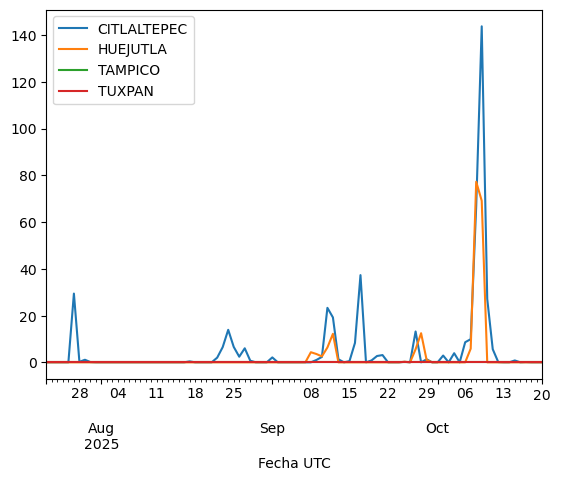

In [29]:
df_hourly.plot()

# HighResMIP Nino3.4 covariate

In [ ]:
fl = glob.glob("/home/cb2714/Downloads/nino*SST*.nc")

In [110]:
for fnm in glob.glob("ts/pr-rx3day*SST*"):
    mdl =  "_".join(fnm.split("_")[2:5])
    nino_fnm = glob.glob("/home/cb2714/Downloads/*"+re.sub("SST", "SST-future",mdl)+"*")

    if len(nino_fnm) != 1: continue

    ds = xr.open_dataset(nino_fnm[0]).nino34_det
    ds = ds.sel(time = ds.time.dt.month.isin([9]))

    df = ds.assign_coords(time = ds.time.dt.year).rename(time = "year").to_dataframe()

    csv_fnm = "mexico-floods_nino3.4-sep_HighResSST_"+re.sub("highresSST_","",mdl)
    csv_fullpath = "ts/"+csv_fnm+".dat"
    if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)
    
    # create header lines for upload to Climate Explorer 
    str1 = "# contact :: CMIP6 HighResSST "+re.sub("highresSST_","",mdl)+" September ENSO index - Mexico floods, c.barnes22@imperial.ac.uk"
    str2 = "# nino34-sep [degC] September detrended Nino3.4 index at "+csv_fnm+".dat"
    head = "# year nino34-sep"

    # make .dat file
    ! echo "$str1 " > $csv_fullpath
    ! echo "$str2" >> $csv_fullpath
    ! echo "$head" >> $csv_fullpath
    df.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

! Filename too long:  mexico-floods_nino3.4-sep_HighResSST_HadGEM3-GC31-LM_r1i14p1f1


## September Nino time series

In [ ]:
nino = pd.read_csv("../10_misc/detrended_nino34/nino34.csv", index_col = "time", parse_dates = ["time"])

nino = nino.loc[nino.index.month.isin([9])]
nino.index = nino.index.year

csv_fnm = "mexico-floods_nino3.4-sep"
csv_fullpath = "ts/"+csv_fnm+".dat"
if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)

# create header lines for upload to Climate Explorer 
str1 = "# contact :: September ENSO index - Mexico floods, c.barnes22@imperial.ac.uk"
str2 = "# nino34-sep [degC] September detrended Nino3.4 index at "+csv_fnm+".dat"
head = "# year nino34-sep"

# make .dat file
! echo "$str1 " > $csv_fullpath
! echo "$str2" >> $csv_fullpath
! echo "$head" >> $csv_fullpath
nino.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

# Climate model time series

## CORDEX

In [111]:
for varnm in ["rx3day", "pr-jjaso"]:
    fl = sorted(glob.glob("ts/*"+varnm+"_CAM*.nc"))

    desc1 = {"rx3day" : "rx3day",
             "pr-jjaso" : "JJASO precipitation"}[varnm]

    desc2 = {"rx3day" : "annual maxima of 3-day accumulated precipitation averaged over eastern Mexico",
             "pr-jjaso" : "June-October accumulated precipitation averaged over eastern Mexico#"}[varnm]
    
    for fnm in fl:
        print(fnm)

        mdl = "_".join(fnm.split("_")[1:5])

        csv_fnm = "mexico-floods_"+varnm+"_"+mdl
        csv_fullpath = "ts/"+csv_fnm+".dat"
        if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)
        
        # create header lines for upload to Climate Explorer 
        str1 = "# contact :: CORDEX "+re.sub("_"," ",mdl)+" "+desc1+" - Mexico floods, 2025, c.barnes22@imperial.ac.uk"
        str2 = "# "+desc2+" at "+csv_fnm+".dat"
        head = "# year "+varnm
        
        # make .dat file
        ! echo "$str1 " > $csv_fullpath
        ! echo "$str2" >> $csv_fullpath
        ! echo "$head" >> $csv_fullpath
    
        ts = pd.read_csv(fnm, sep = " ", index_col = "year").dropna(axis = 0, how = "any")
        ts.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)
clear_output(wait = False)
print("Done.")

Done.


## HighResMIP

In [113]:
for varnm in ["rx3day", "pr-jjaso"]:
    fl = sorted(glob.glob("ts/*"+varnm+"*SST*.nc"))

    desc1 = {"rx3day" : "rx3day",
             "pr-jjaso" : "JJASO precipitation"}[varnm]

    desc2 = {"rx3day" : "annual maxima of 3-day accumulated precipitation averaged over eastern Mexico",
             "pr-jjaso" : "June-October accumulated precipitation averaged over eastern Mexico#"}[varnm]
    
    for fnm in fl:
        print(fnm)
        mdl = re.sub("highresSST_","","_".join(fnm.split("_")[2:5]))

        csv_fnm = "mexico-floods_HighResSST_"+varnm+"_"+mdl
        csv_fullpath = "ts/"+csv_fnm+".dat"
        if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)

        # create header lines for upload to Climate Explorer 
        str1 = "# contact :: CMIP6 HighResSST "+re.sub("_"," ",mdl)+" "+desc1+" - Mexico floods, 2025, c.barnes22@imperial.ac.uk"
        str2 = "# "+desc2+" at "+csv_fnm+".dat"
        head = "# year "+varnm

        # make .dat file
        ! echo "$str1 " > $csv_fullpath
        ! echo "$str2" >> $csv_fullpath
        ! echo "$head" >> $csv_fullpath
    
        ts = pd.read_csv(fnm, sep = " ", index_col = "year").dropna(axis = 0, how = "any")
        ts.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)
clear_output(wait = False)
print("Done.")

Done.
